In [1]:
from model import LIP_SSL_Model

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from utils import decode_labels
from PIL import Image
import cv2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import tensorflow.contrib.eager as tfe
%matplotlib inline

In [2]:
# tf.enable_eager_execution()

Text(0.5, 0.01, 'datasets/examples/images/_LLL0519.jpg')

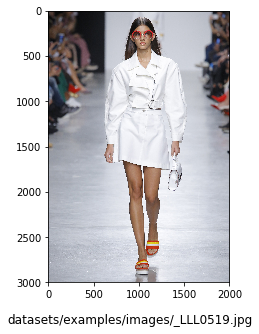

In [74]:
sample_path = 'datasets/examples/images/_LLL0519.jpg'
sample_input = plt.imread(sample_path)

plt.imshow(sample_input)
plt.figtext(0.5, 0.01, sample_path, wrap=True, horizontalalignment='center', fontsize=12)

In [76]:
# tf.enable_eager_execution()
fine_width, fine_height = 384, 384
n_channels = 3

def preprocess(input_path, fine_width, fine_height):
    """Load image from disk and convert to tensor object"""
    
    im = cv2.imread(input_path)
    im_resize = cv2.resize(im,(fine_width, fine_height))
    im_ = im_resize.astype(np.float32)
#     im_ = np.expand_dims(im_, axis=0)
    print(im_.shape)
    
    # convert to tensor object
    im_tf = tf.convert_to_tensor(im_)
    im_reversed_tf = tf.reverse(im_tf, tf.stack([1]))
    print(im_reversed_tf.shape)
    print(im_tf.shape)
    return tf.stack([im_tf, im_reversed_tf], axis=0)

def preprocess2(input_path, fine_width, fine_height):
    image_contents = tf.read_file(input_path)
    img = tf.image.decode_jpeg(image_contents)
    img_r, img_g, img_b = tf.split(value=img, num_or_size_splits=3, axis=2)
    img = tf.cast(tf.concat([img_r, img_g, img_b], 2), dtype=tf.float32)
    img -= np.array((104.00698793,116.66876762,122.67891434), dtype=np.float32)
    
    im_resized = tf.image.resize_images(img, size=[fine_width, fine_height])
    
    im_reversed_tf = tf.reverse(im_resized, tf.stack([1]))
    return tf.stack([im_resized, im_reversed_tf], axis=0)

In [77]:
def count_number_trainable_params():
    '''
    Counts the number of trainable variables.
    '''
    tot_nb_params = 0
    for trainable_variable in tf.trainable_variables():
        shape = trainable_variable.get_shape() # e.g [D,F] or [W,H,C]
        current_nb_params = get_nb_params_shape(shape)
        tot_nb_params = tot_nb_params + current_nb_params
    return tot_nb_params

def get_nb_params_shape(shape):
    '''
    Computes the total number of params for a given shap.
    Works for any number of shapes etc [D,F] or [W,H,C] computes D*F and W*H*C.
    '''
    nb_params = 1
    for dim in shape:
        nb_params = nb_params*int(dim)
    return nb_params 

In [78]:
tf.reset_default_graph()

inputs = tf.placeholder(dtype=tf.string)

inputs_preprocess = preprocess2(inputs, fine_width, fine_height)
# inputs = tf.placeholder(tf.float32, shape=(None, 2, fine_width, fine_height, n_channels))
ssl_model = LIP_SSL_Model(384, 384)
# restore weight from eager mode
checkpoints = './checkpoint/JPPNet-s2/'
# ssl_model.load_weights(tf.global_variables(), sess, checkpoints)
pred_all = ssl_model.forward(inputs_preprocess)

In [79]:
count_number_trainable_params()

107817296

In [80]:
# Set up tf session and initialize variables. 
config = tf.ConfigProto()
# config.gpu_options.allow_growth = True

init = tf.global_variables_initializer()
pretrained = True

with tf.Session(config=config) as sess:
    if pretrained:
        ssl_model.load_weights(tf.global_variables(), sess, checkpoints)
    else:
        sess.run(init)
        sess.run(tf.local_variables_initializer())
    
    parsing_ = sess.run(pred_all, feed_dict={inputs : sample_path})

INFO:tensorflow:Restoring parameters from ./checkpoint/JPPNet-s2/model.ckpt-205632
Restored model parameters from model.ckpt-205632
Loaded model successfully


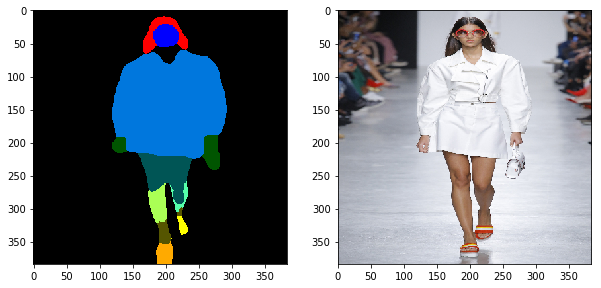

In [82]:
msk = decode_labels(parsing_, num_classes=20)

parsing_im = Image.fromarray(msk[0])
plt.subplot(1, 2, 1)
plt.imshow(np.array(parsing_im))

input_im = cv2.imread(sample_path)
input_im_rz = cv2.resize(input_im, (fine_width, fine_height))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(input_im_rz, cv2.COLOR_BGR2RGBA))